In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from matplotlib import scale
from matplotlib.scale import ScaleBase
from matplotlib.transforms import Transform

plt.rcParams['font.family'] = ['Arial']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
class CustomTransform(Transform):
    input_dims = 1
    output_dims = 1
    is_separable = True
    
    def __init__(self, data_points):
        Transform.__init__(self)
        self.data_points = data_points
        self.display_points = np.linspace(0, 1, len(data_points))
    
    def transform_non_affine(self, a):
        return np.interp(a, self.data_points, self.display_points)
    
    def inverted(self):
        return InvertedCustomTransform(self.data_points)

class InvertedCustomTransform(Transform):
    input_dims = 1
    output_dims = 1
    is_separable = True
    
    def __init__(self, data_points):
        Transform.__init__(self)
        self.data_points = data_points
        self.display_points = np.linspace(0, 1, len(data_points))
    
    def transform_non_affine(self, a):
        return np.interp(a, self.display_points, self.data_points)
    
    def inverted(self):
        return CustomTransform(self.data_points)

class CustomScale(ScaleBase):
    name = 'custom'
    
    def __init__(self, axis, **kwargs):
        super().__init__(axis)
        self.data_points = kwargs.get('data_points', [0.0, 0.5, 1, 3, 5])
        self.data_points = sorted(self.data_points)

        self.minor_points = kwargs.get('minor_points', [])
        self.minor_points = sorted(self.minor_points)
    
    def get_transform(self):
        return CustomTransform(self.data_points)
    
    def set_default_locators_and_formatters(self, axis):
        from matplotlib.ticker import FixedLocator, FixedFormatter
        axis.set_major_locator(FixedLocator(self.data_points))
        axis.set_major_formatter(FixedFormatter([str(x) for x in self.data_points]))
        if self.minor_points:
            axis.set_minor_locator(
                FixedLocator(self.minor_points)
            )

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return self.data_points[0], self.data_points[-1]

In [ ]:
regionS, folder = dict(), 'static_infos\\classification_Trans_1035'
columns2keep = {
    'Invasion': '#54B345',
    'Herbicide control': '#8E8BFE',
    'Mowing 1st': '#C82423',
    'Waterlogging': '#547BB4',
    'WL_fast': '#547BB4',
    'Mowing 2nd': '#BB9727',
    'Recurring': '#6F6F6F',
    'Mangrove': "#FF00F7",
    'date': None,
    'No change': None,
    'removal_rate': None
}
provinces = ['SD', 'JS', 'SH', 'ZJ', 'FJ', 'GDGX']
# Clipped to 2022
# provincely_area = [8706.15, 19530.88, 15407.28, 18115.83, 7545.82, 231.82]  # Static date range
# expanded Area (_2022)
provincely_area = [9738.14, 22118.91, 19000.46, 20731.01, 9149.99, 1768.82]

for file in os.listdir(folder):
    if file == 'imgs': continue
    file_path = os.path.join(folder, file)
    raw_data = pd.read_csv(file_path)
    region = raw_data['region'].head().values[0]
    raw_data['date'] = pd.to_datetime(raw_data['date'])
    raw_data['removal_rate'] = None
    regionS.update({region: raw_data[columns2keep.keys()]})

for area, province in zip(provincely_area, provinces):
    if province == 'GDGX': continue
    dates = regionS[province]['date']

    removal = regionS[province][['Herbicide control', 'Mowing 1st', 'Mowing 2nd', 'WL_fast']].sum(axis=1)
    recurring = regionS[province]['Recurring']
    const_calc = removal - recurring    # constant part
    
    restoration = regionS[province]['Mangrove']
    restoration_total = restoration.sum()
    
    invasion = regionS[province]['Invasion']    # float part
    invasion_total = invasion.sum()

    const_tf, const_wb, const_mg = regionS[province]['No change'].iloc[0], \
                                regionS[province]['No change'].iloc[1], \
                                regionS[province]['No change'].iloc[-1]
    # SA = area - const_tf - const_wb - const_mg - invasion_total
    SA = area
    new_df = pd.DataFrame({
        'date': dates,
        'const_calc': const_calc,
        'invasion': invasion,
        'removal_rate': None
    })
    monthly_invasion, monthly_const_calc = 0, 0
    for idx, row in new_df.iterrows():
        monthly_invasion, monthly_const_calc = monthly_invasion + row['invasion'], \
                                               monthly_const_calc + row['const_calc']
        # removal_rate = ((SA + monthly_invasion) - monthly_const_calc) / (SA + monthly_invasion)
        removal_rate = (SA - monthly_const_calc) / SA
        removal_rate = 1 - removal_rate
        new_df.loc[idx, 'removal_rate'] = removal_rate * 100
        
    regionS[province].loc[:, 'removal_rate'] = new_df['removal_rate']
    
    province_data = regionS[province]

    # if province == 'SD':
    #     print('myk: 6969 ha.')
    #     start_date, end_date = pd.to_datetime('2021-01-01'), pd.to_datetime('2022-01-01')
    # elif province == 'FJ':
    #     print('myk: 6501 ha.')
    #     start_date, end_date = pd.to_datetime('2022-01-01'), pd.to_datetime('2023-01-01')
    # elif province == 'SH':
    #     start_date, end_date = pd.to_datetime('2020-01-01'), pd.to_datetime('2025-01-01')
    # else:
    #     if province == 'ZJ': print('myk: 12707 ha.')
    #     if province == 'JS': print('myk: 9882 ha.')
    #     start_date, end_date = pd.to_datetime('2020-01-01'), pd.to_datetime('2025-01-01')
        
    start_date, end_date = pd.to_datetime('2020-01-01'), pd.to_datetime('2025-01-01')
        
    print(f'province: {province}, area: {area:.2f} ha - {area * 15:.2f} mu')
    mask = (province_data['date'] >= start_date) & (province_data['date'] <= end_date)
    print(f'date range: {start_date.date()} to {end_date.date()}')
    filtered_data = province_data[mask]
    # sum（Mowing 1st + Mowing 2nd + Herbicide control）
    sum_mowing_herb = filtered_data[['Mowing 1st', 'Mowing 2nd', 'Herbicide control', 'WL_fast']].sum().sum()
    # sum_mowing_herb = filtered_data[['Mowing 1st', 'Herbicide control', 'WL_fast']].sum().sum()
    [print(f'{evt}:\t\t|{filtered_data[evt].sum():.2f}|ha - {filtered_data[evt].sum() * 15:.2f} mu') \
        # for evt in ['Mowing 1st', 'Mowing 2nd', 'Herbicide control', 'WL_fast', 'Recurring']]
        for evt in ['Recurring', 'WL_fast', 'Waterlogging', 'Herbicide control', 'Mowing 1st', 'Mowing 2nd']]
    final_removal_rate = filtered_data['removal_rate'].iloc[-1]
    print(f'removal sum: \t\t|{sum_mowing_herb:.2f}|ha - {sum_mowing_herb * 15:.2f} mu')
    print(f'Restoration sum: \t|{restoration_total:.2f}|ha - {restoration_total * 15:.2f} mu')
    print(f'final removal rate: \t|{final_removal_rate:.2f}|%')
    recurrence_rate = filtered_data['Recurring'].sum() / (filtered_data['Mowing 1st'].sum() + filtered_data['Chemical control'].sum())
    print(f'recurrence rate: \t|{recurrence_rate * 100:.2f}|%')
    print('=' * 50)

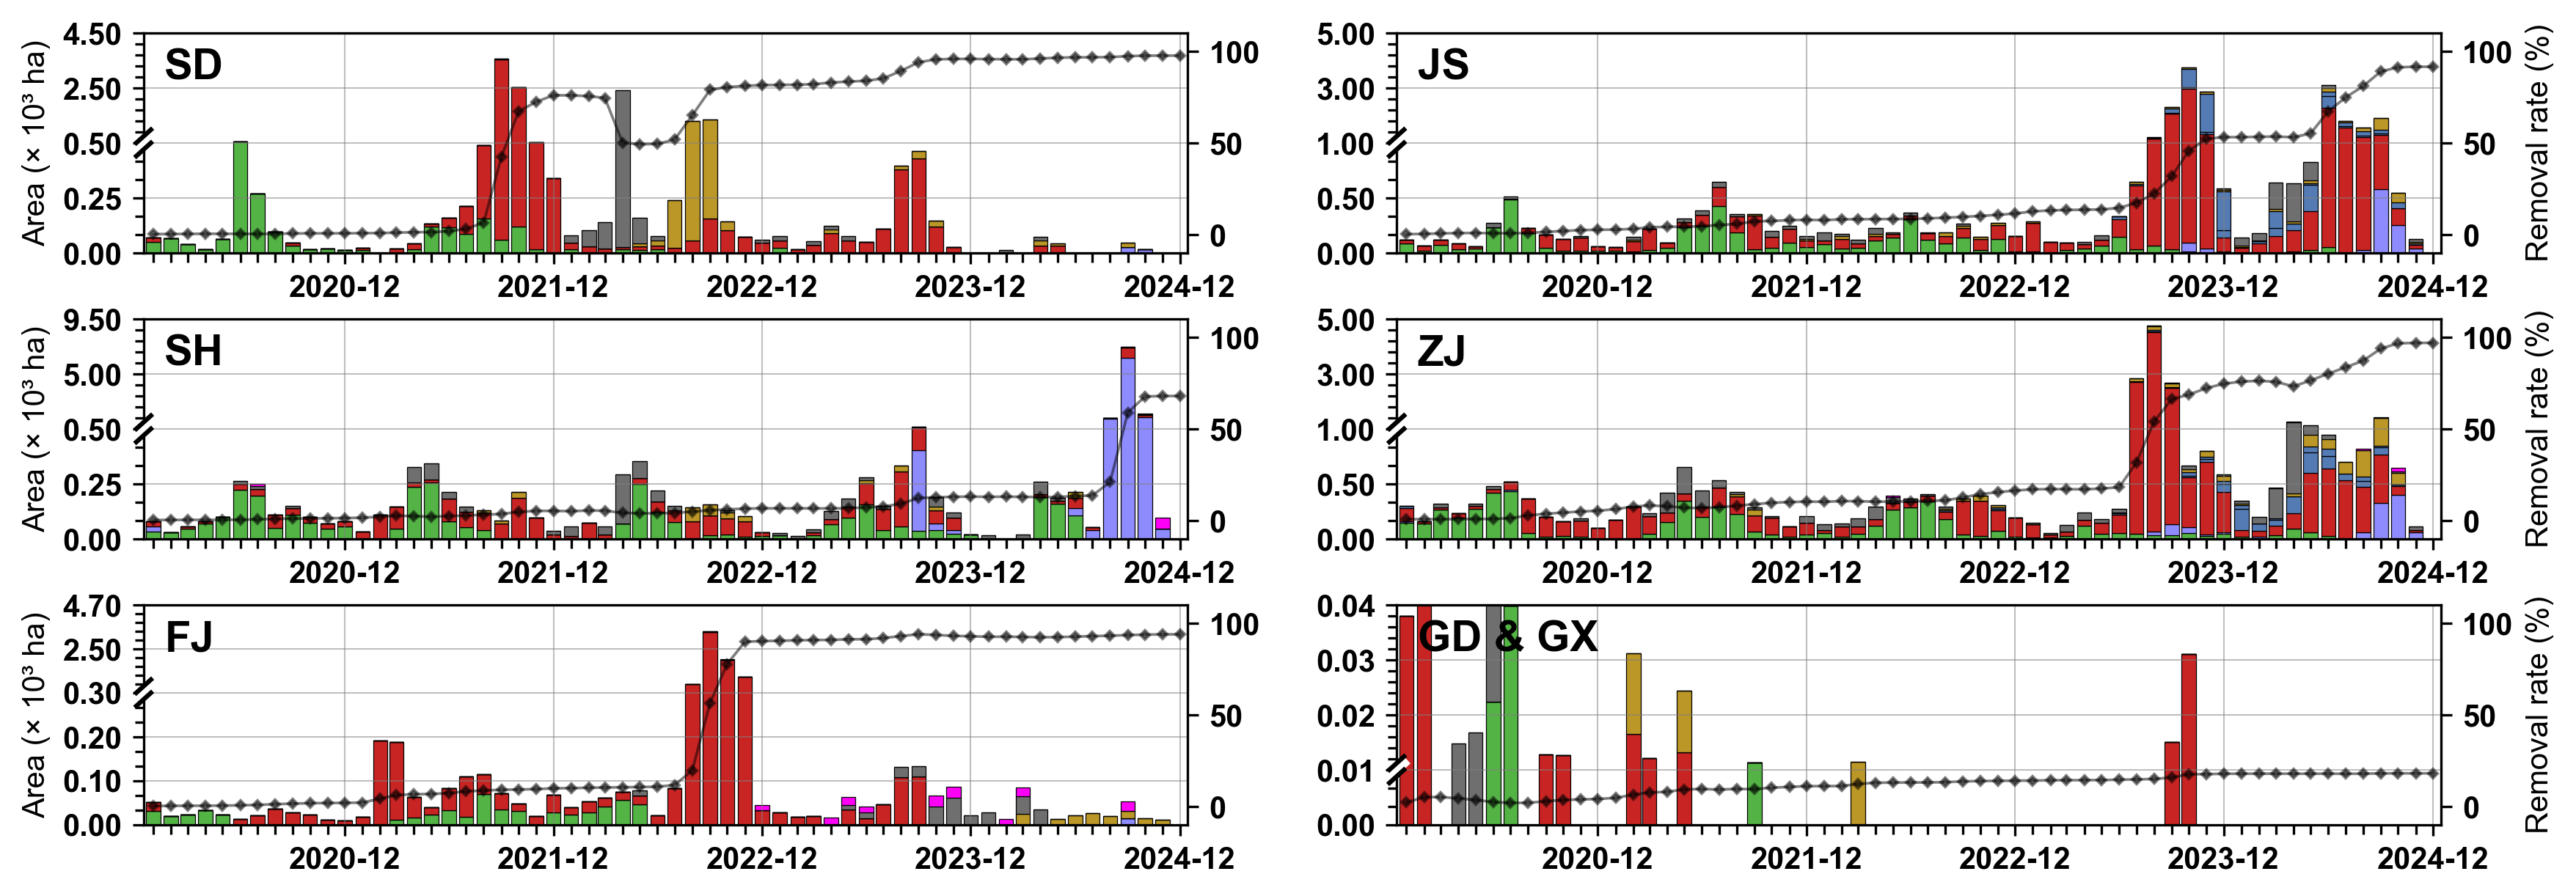

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.transforms as mtrans
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter

scale.register_scale(CustomScale)

n_cols, global_legends = 2, None
n_rows = (len(provinces) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 1.5 * n_rows), dpi=300)
fig.subplots_adjust(hspace=0.6)

scales = {
    'SD': ([0.0, 0.25, 0.5, 2.5, 4.5], 0.5),
    'JS': ([0.0, 0.5, 1.0, 3.0, 5.0], 1.0),
    'ZJ': ([0.0, 0.5, 1.0, 3.0, 5.0], 1.0),
    'SH': ([0.0, 0.25, 0.5, 5.0, 9.5], 0.5),
    'FJ': ([0.0, 0.1, 0.2, 0.3, 2.5, 4.7], 0.3),
    'GDGX': ([0, 0.05, 0.1, 0.15, 0.2], 0.1)
}

for idx, province in enumerate(provinces):
    if province == 'GDGX': 
        continue
    i, j = idx // n_cols, idx % n_cols
    _ax_ = axs[i, j]
    ax2 = _ax_.twinx()
    for spine in list(ax2.spines.values()):
        spine.set_visible(False)
    bar_bottom, legends = None, list()

    # scaled y axis in different value range
    # =========== Break axis vfx start ============
    minor_points = list()
    for a, b in zip(scales[province][0][:-1], scales[province][0][1:]):
        if a >= scales[province][1]:
            delta = (b - a) / 5
            minor_points.extend([a + i * delta for i in range(5)])
        else:
            delta = (b - a) / 3
            minor_points.extend([a + i * delta for i in range(3)])

    _ax_.set_yscale('custom', data_points=scales[province][0], minor_points=minor_points)

    non_line_bry = scales[province][0].index(scales[province][1])
    bp_loc, n = scales[province][0][non_line_bry], len(scales[province][0]) - 1
    
    # y_bp_up, y_bp_low = (non_line_bry / n) + (1 / (4*n)) + 0.03 , (non_line_bry / n) + (1 / (4*n)) - 0.03
    y_bp_up, y_bp_low = (non_line_bry / n) + 0.03 , (non_line_bry / n) - 0.03
    x_range = [-0.007, 0.007]
    
    trans = mtrans.blended_transform_factory(_ax_.transAxes, _ax_.transAxes)
    _ax_.plot(x_range, 
            [y_bp_up - 0.03, y_bp_up + 0.03],
            **({'color': 'black'}),
            transform=trans, clip_on=False, zorder=10)
    
    _ax_.plot(x_range, 
            [y_bp_low, y_bp_up], zorder=9,
            **({'color': 'white', 'linewidth': 3, 'alpha': 1}),
            transform=trans, clip_on=False)
    
    _ax_.plot(x_range, 
            [y_bp_low - 0.03, y_bp_low + 0.03],
            **({'color': 'black'}),
            transform=trans, clip_on=False, zorder=10)
    
    height = y_bp_up - y_bp_low - 0.035
    rect = Rectangle((0, y_bp_low-0.03), 1, height,
                     transform=ax.transAxes,
                     facecolor='white',
                     edgecolor='none',
                     clip_on=False,
                     zorder=5)
    ax.add_patch(rect)
    # =========== Break axis vfx end ===========
    region2show = regionS[province]
    # =========== Plotting the data ============
    for idx_evt, evt in enumerate(columns2keep.keys()):
        if evt == 'date' or evt == 'No change': continue
        if evt == 'removal_rate':
            foo = region2show[evt]
            if province == 'SH':
                foo = region2show[evt] * 1.4
            elif province == 'ZJ':
                foo = region2show[evt] * 1.1
            elif province == 'SD':
                foo = region2show[evt] * 0.99
                
            ax2.plot(region2show['date'], foo, 
                     label='Removal rate',
                     markersize=2, marker='D', 
                     linestyle='-', linewidth=0.9, color='black', alpha=0.5
                     )
            ax2.set_ylim(-10, 110)
            continue
        # remove value < 5 ha
        values_lt_1 = region2show.select_dtypes(include='number').columns
        region2show.loc[:, values_lt_1] = region2show[values_lt_1].where(
            region2show[values_lt_1] >= 5,
            0
        )
        # Bar
        bar_color = list(columns2keep.values())[idx_evt]
        _ax_.bar(region2show['date'], region2show[evt] / 1000, bottom=bar_bottom, \
               color=bar_color, alpha=1, width=25, label=evt,
               edgecolor='black', linewidth=0.3)
        
        if evt != 'WL_fast':
            legends.append(mpatches.Patch(color=list(columns2keep.values())[idx_evt], label=evt))
        bar_bottom = bar_bottom + region2show[evt] / 1000 if bar_bottom is not None else region2show[evt] / 1000
    # =========== End of plotting data ============

    _ax_.set_xlim(pd.Timestamp('2019-12-15'), pd.Timestamp('2024-12-15'))
    if j == 0: _ax_.set_ylabel('Area (× 10³ ha)')
    else: 
        _ax_.set_ylabel('') # Hide y-axis label for subplots in the second column
        ax2.set_ylabel('Removal rate (%)')
    
    _ax_.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    _ax_.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
    _ax_.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    _ax_.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ======================================================================================================================================
    _ax_.tick_params(
        which='minor',
        length=3,
        width=0.8,
        direction='out'
    )
        
    _ax_.grid(which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
    _ax_.text(
        0.02, 0.75,
        f'{province}',
        ha='left', va='bottom',
        fontsize=14,
        fontweight='bold',
        transform=_ax_.transAxes
    )

if len(provinces) % n_cols != 0:
    axs[-1, -1].axis('off')

if global_legends is not None:
    ax.legend(
        handles=legends, 
        # bbox_to_anchor=(-0.15, -0.4),
        bbox_to_anchor=(1, -0.4),
        ncol=len(global_legends),
        frameon=False,
        markerscale=1.5,
        loc='upper center')
    ax2.legend(
        bbox_to_anchor=(0.65, 3.75),
        frameon=False,
        loc='upper left',
        markerscale=3
    )
    
fig.subplots_adjust(
    hspace=0.2,   # 垂直间距从0.6缩小到0.3（根据实际效果调整）
    wspace=0.2,  # 新增水平间距控制（默认较大，缩小为0.15）
    left=0.08,    # 左边距缩小（原默认0.125）
    right=0.95,   # 右边距扩大（减少右侧空白）
    top=0.95,     # 顶部边距缩小（减少顶部空白）
    bottom=0.15   # 底部边距调整（配合图例位置）
)
axs[-1, -1].set_visible(False)
plt.show()

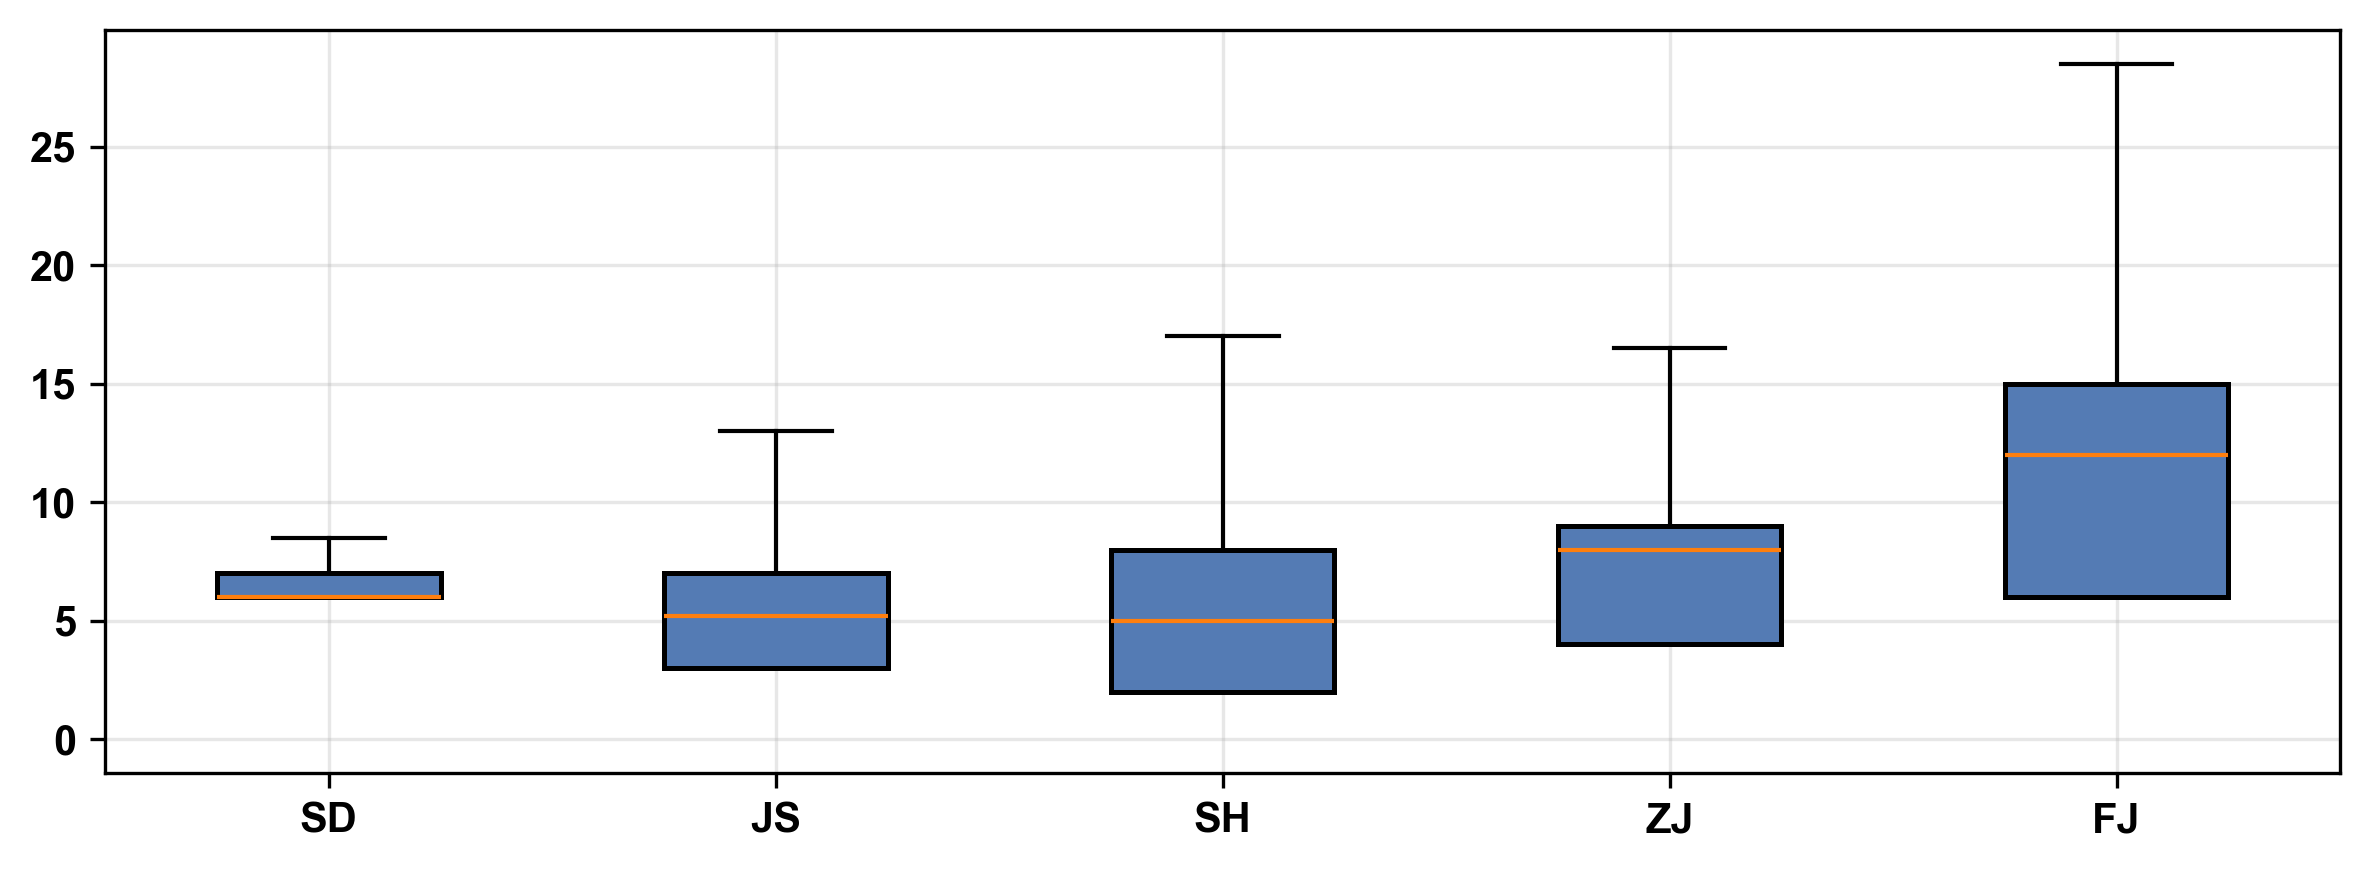

In [34]:
recur_after_mow = {
    'SD': [6, 6, 7],
    'JS': [5.199824181, 3, 7],
    'SH': [5, 2, 8],
    'ZJ': [8, 4, 9],
    'FJ': [12, 6, 15]
}

# 准备统计数据
stats = []
provinces = list(recur_after_mow.keys())

for i, province in enumerate(provinces):
    median, q1, q3 = recur_after_mow[province]
    
    # 计算IQR和须线位置（假设最小值和最大值基于1.5倍IQR）
    iqr = q3 - q1
    whislo = max(0, q1 - 1.5 * iqr)
    whishi = q3 + 1.5 * iqr
    
    stat_dict = {
        'med': median,      # 中位数
        'q1': q1,          # 第一四分位数
        'q3': q3,          # 第三四分位数
        'whislo': whislo,  # 下须线
        'whishi': whishi,  # 上须线
        'fliers': [],      # 异常值（空列表）
        'label': province  # 标签
    }
    stats.append(stat_dict)

# 绘制箱型图
_fig, _ax_ = plt.subplots(figsize=(8, 3), dpi=300)
boxplot_dict = _ax_.bxp(stats, positions=range(len(stats)), showfliers=True, patch_artist=True)
# _ax_.set_ylim(0, 50)

for i, box in enumerate(boxplot_dict['boxes']):
    box.set_facecolor('#547BB4')
    # box.set_alpha(0.7)
    box.set_edgecolor('black')
    box.set_linewidth(1.2)


for i in range(len(provinces)):
    boxplot_dict['whiskers'][i*2].set_visible(False)
    boxplot_dict['caps'][i*2].set_visible(False)

_ax_.set_xticks(range(len(stats)))
_ax_.set_xticklabels(provinces)
# _ax_.set_ylabel('Days After Mowing')
# _ax_.set_title('Recurring After Mowing by Province')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()